<a href="https://colab.research.google.com/github/etemadism/Courses/blob/main/03_Paired_Sample_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# **Paired (dependent) Sample Analysis with Python**
This notebook performs statistical analysis on paired sample data, allowing comparison between pre- and post-treatment conditions for multiple factors. It automates the process of:  

1. **Normality Testing**: Determines whether the data for each factor follows a normal distribution.
2. **Statistical Testing**: Applies the appropriate paired test (paired t-test for normal data or Wilcoxon signed-rank test for non-normal data) to compare pre- and post-treatment conditions.
3. **Result Summarization**: Computes the mean, mean difference, test statistics, p-values, and 95% confidence intervals for each factor.
4. **Visualization**: Creates box plots for significant factors to visualize the differences.

## **Input Requirements**
1. **Dataset Format**:
   - The input dataset should be in a CSV format.
   - Each factor being analyzed should have two paired columns: one representing pre-treatment values and the other representing post-treatment values.  

2. **Column Naming Convention**:
   - Paired columns must use the suffix `_1` for pre-treatment values and `_2` for post-treatment values.  
   - For example:
     - `Glucose_1` (pre-treatment glucose levels)
     - `Glucose_2` (post-treatment glucose levels)  

3. **Unique Factors**: Each pair of columns represents a unique factor, such as `Glucose`, `Blood_Pressure`, or `Cholesterol`.

## **How to Use This Notebook**
1. Upload your CSV file (e.g., `Paired_samples_data.csv`) to the Colab environment.
2. Ensure the columns in the CSV file follow the required naming conventions.
3. Run the cells in sequence. The notebook will automatically:
   - Analyze all paired factors.
   - Identify and highlight significant results.
   - Generate box plots for significant factors.

## **Outputs**
- A results table summarizing the statistical analysis for each factor.
- Box plots for factors that exhibit statistically significant changes.

---
**Data Availability**

For learning purposes, you can access the dataset for this analysis on GitHub. The dataset is hosted on the GitHub account with the username **etemadism**. You can download the data directly from the repository to follow along with the notebook.

GitHub Repository: https://github.com/etemadism

**Author: Ali Etemadi**

Tehran University of Medical Sciences, Tehran, Iran
---

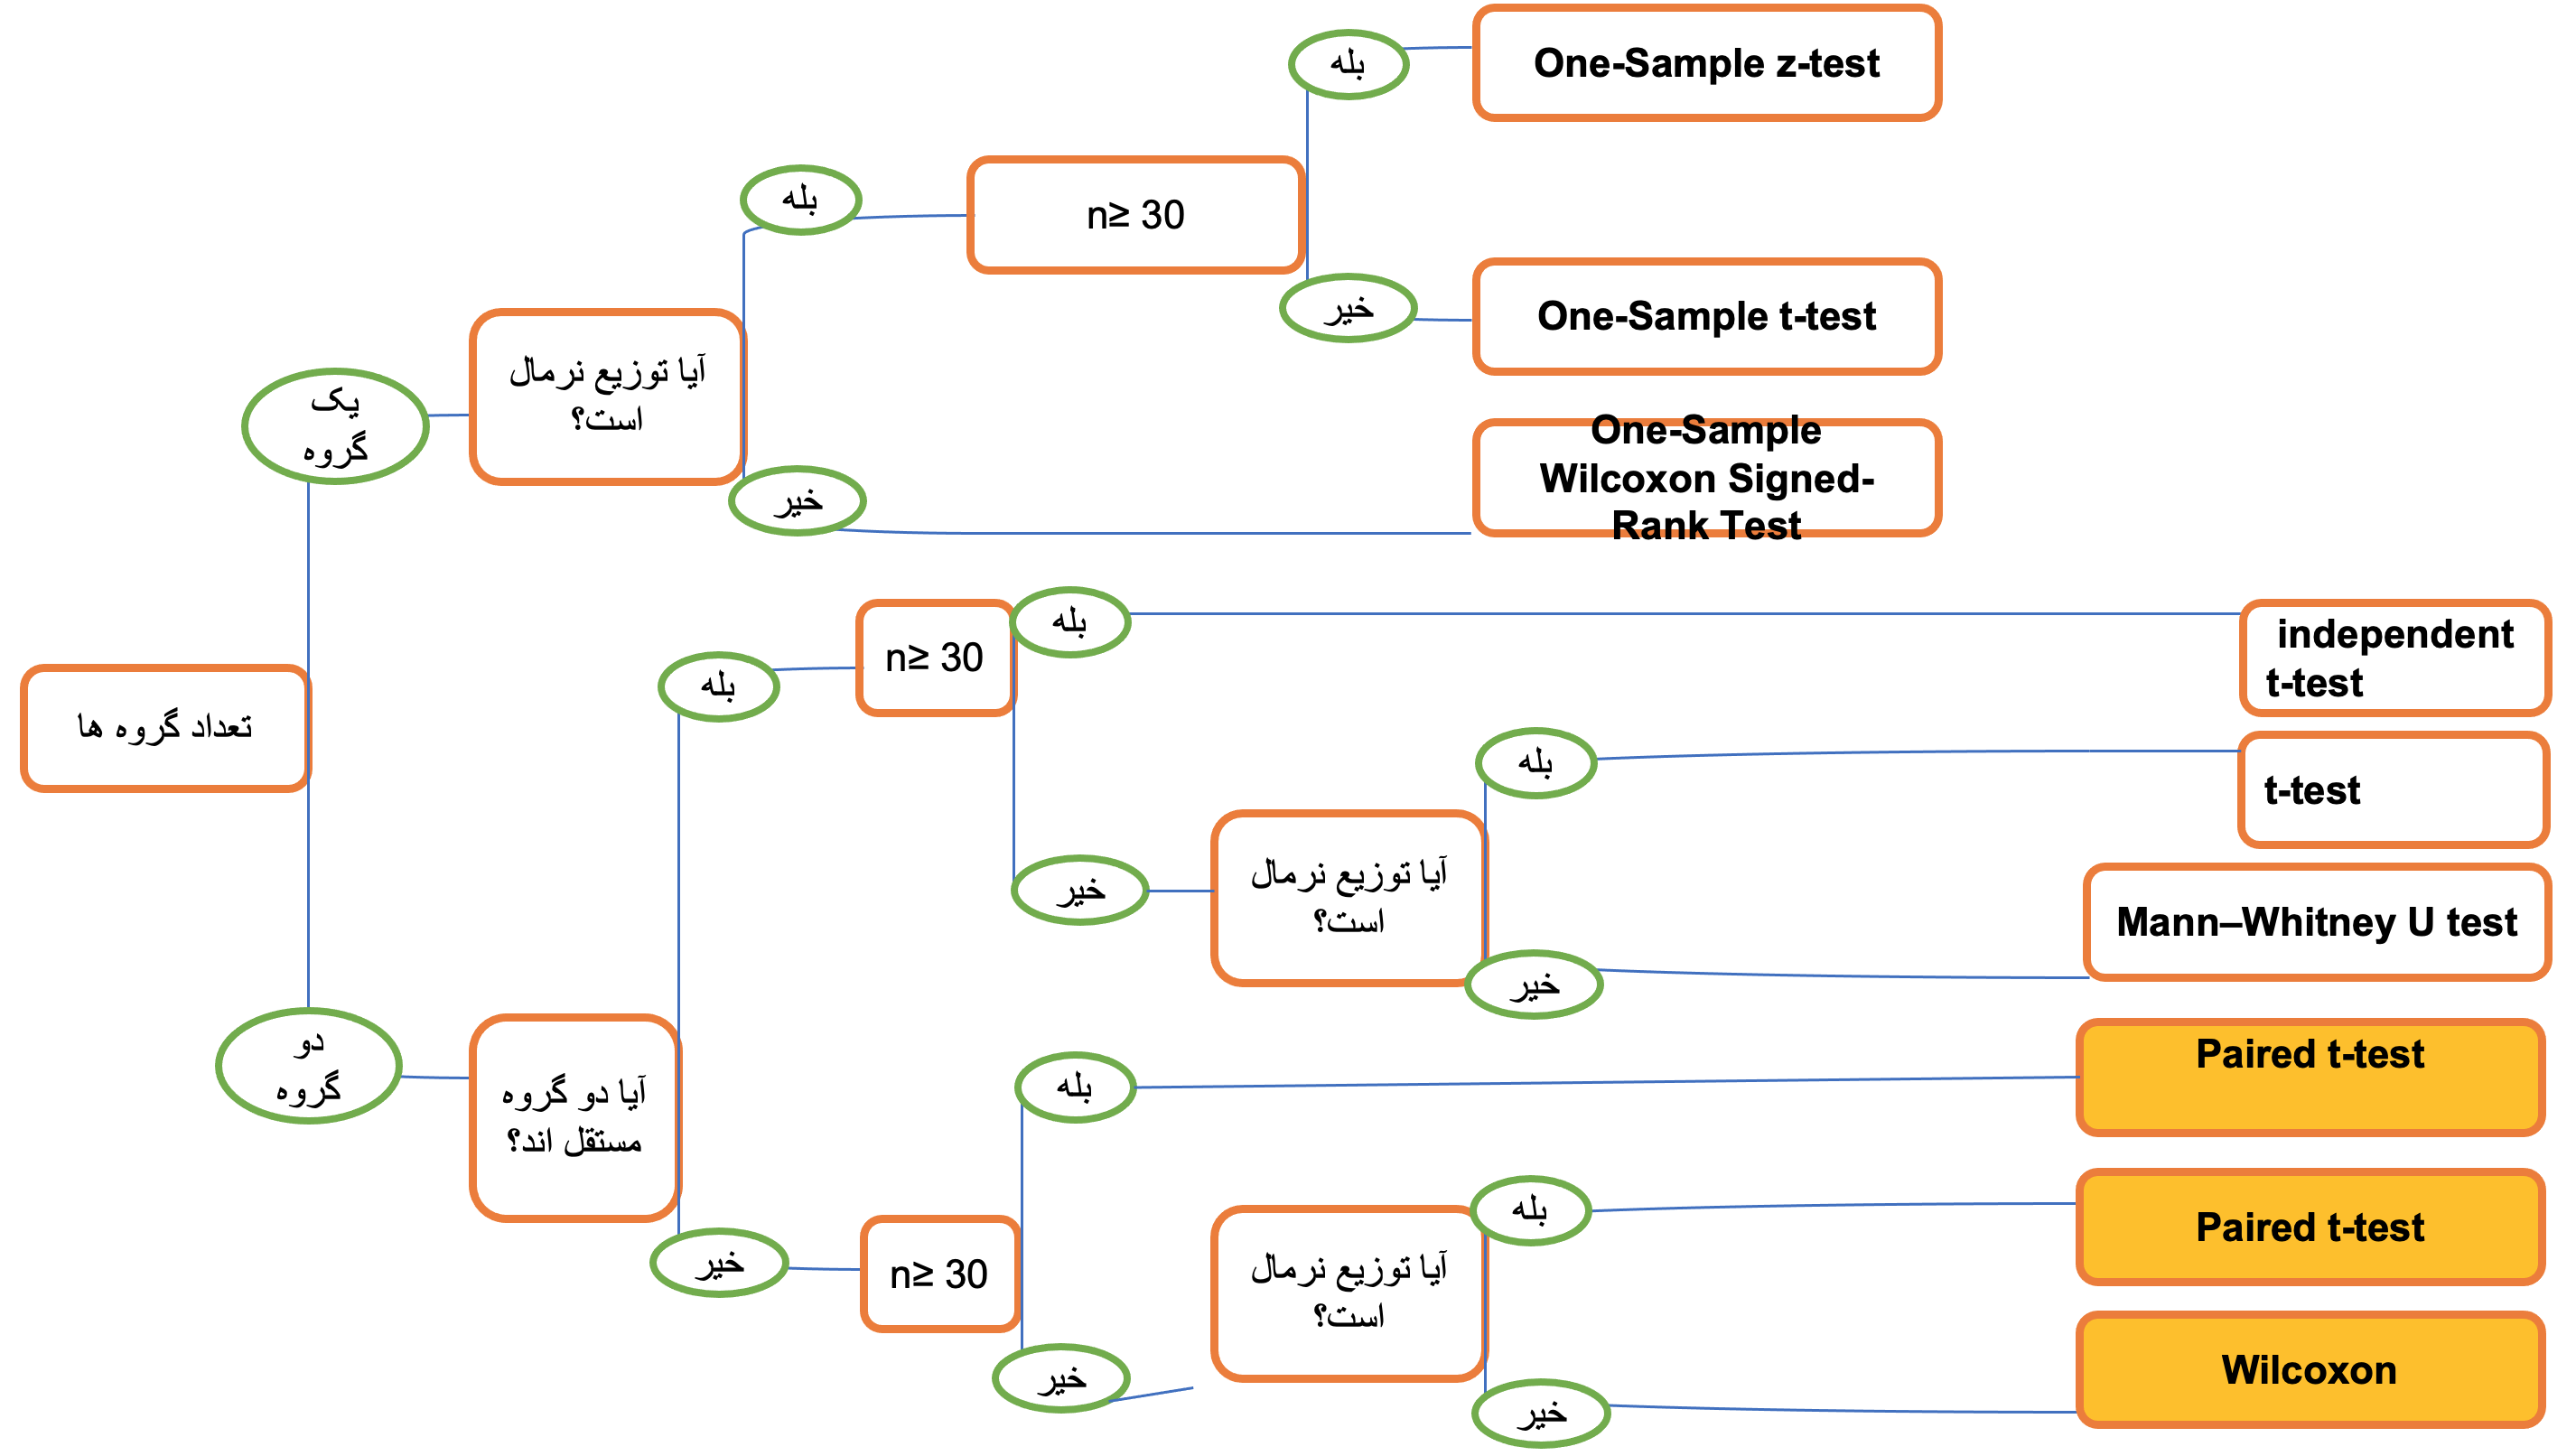


##Step 1: Import Libraries and define groups

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro, kstest
from statsmodels.stats.weightstats import DescrStatsW
import seaborn as sns

##Step 2: Define the Data
Define the data for both groups.

In [42]:
# Load dataset
data = pd.read_csv("/content/Paired_samples_data.csv")
data

,Patients ID,Glucose_1,Glucose_2,Blood_Pressure_1,Blood_Pressure_2,Cholesterol_1,Cholesterol_2,Hemoglobin_1,Hemoglobin_2,Cortisol_1,Cortisol_2,CRP_1,CRP_2
0,1,87.346340,90,119.871689,125,200,190,14.5,14.8,12.0,11.8,3.5,3.2
1,2,103.050607,91,131.142473,126,210,202,14.0,14.5,11.5,11.2,3.8,3.4
2,3,98.583728,96,125.919759,130,220,210,13.8,14.2,11.7,11.5,3.6,3.3
3,4,99.564713,100,125.876963,138,190,185,15.0,15.5,12.2,12.0,3.2,3.1
4,5,89.848124,93,146.656488,129,215,210,13.9,14.1,11.3,11.6,3.7,3.4
5,6,86.847981,88,122.742237,120,205,198,14.3,14.6,12.6,11.9,3.4,3.0
6,7,90.299194,94,130.675282,128,212,205,14.6,15.0,11.8,12.0,3.3,3.2
7,8,94.056154,87,105.752518,118,185,180,14.2,14.5,11.1,11.4,3.1,3.0
8,9,95.595411,95,127.556173,129,225,220,15.1,15.4,12.5,12.3,3.9,3.5
9,10,94.156250,92,128.109226,123,205,198,14.0,14.2,11.4,11.7,3.6,3.2


## Step 3: Perform the paired sample test

In [43]:
# Normality test function
def normality_test(data, threshold=50):
    """Perform Shapiro-Wilk if n < threshold, otherwise Kolmogorov-Smirnov."""
    n = len(data)
    if n < threshold:
        stat, p_value = shapiro(data)
        test = "Shapiro-Wilk"
    else:
        mean = np.mean(data)
        std = np.std(data, ddof=1)
        stat, p_value = kstest(data, 'norm', args=(mean, std))
        test = "Kolmogorov-Smirnov"
    return test, stat, p_value

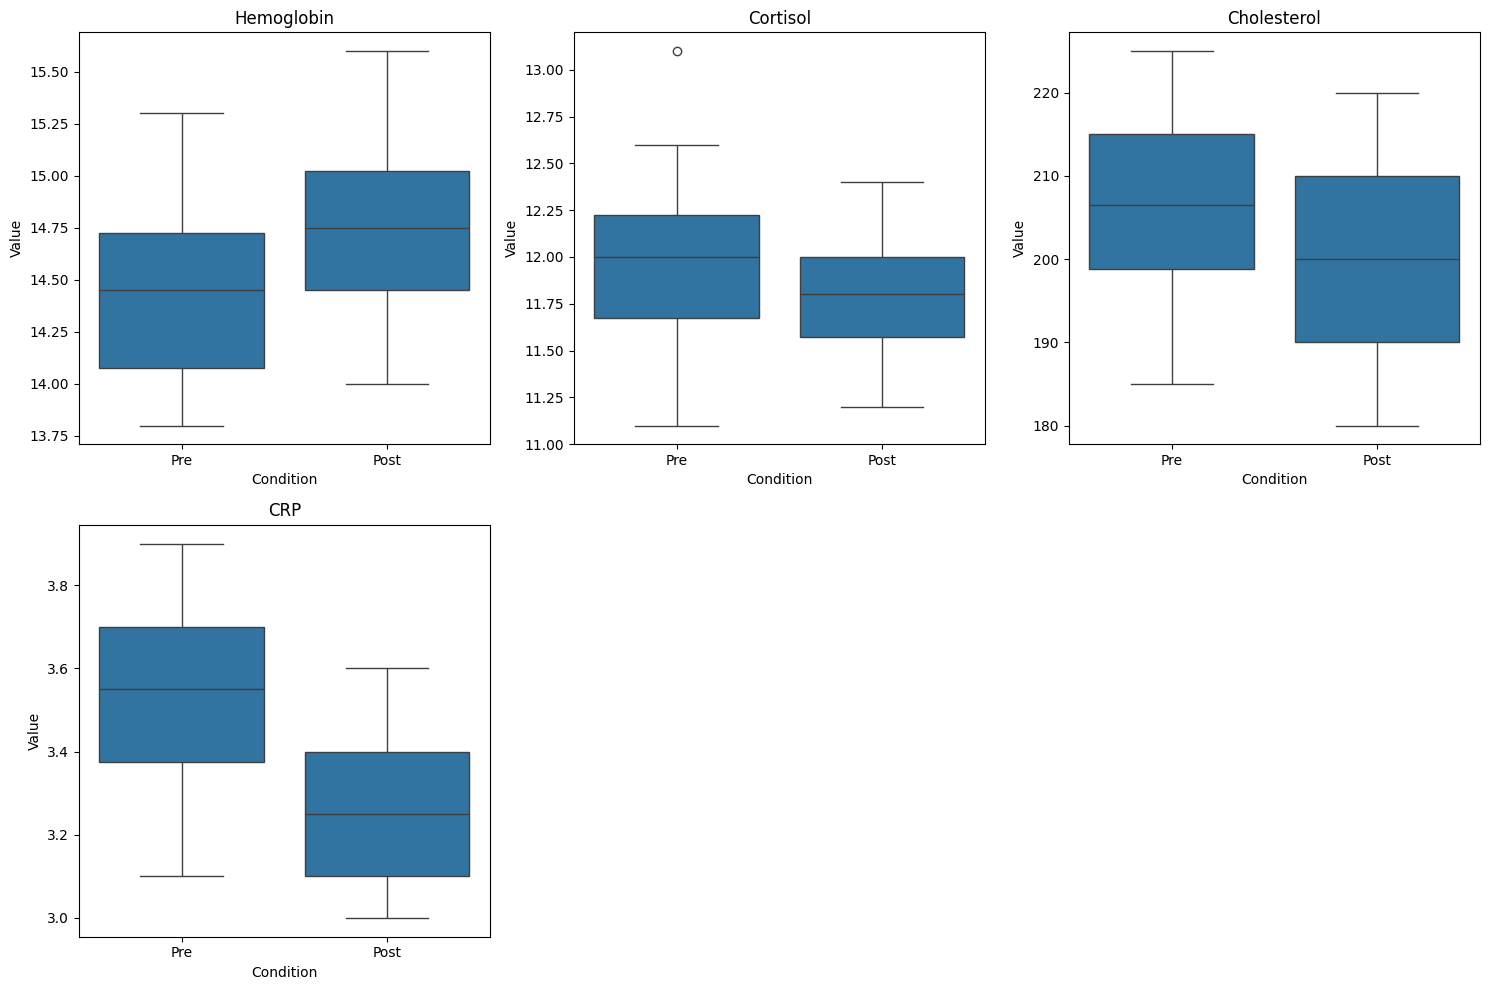

,Factor,Mean (Pre),Mean (Post),Normality Test (Pre),Normality Test (Post),Test Used,Statistic,P-Value,Significant,Mean Difference,95% CI
0,Blood_Pressure,126.271859,125.900,Shapiro-Wilk,Shapiro-Wilk,Paired t-Test,0.182339,8.572484e-01,False,-0.371859,"(-4.640340405614445, 3.896622945614441)"
1,Hemoglobin,14.440000,14.755,Shapiro-Wilk,Shapiro-Wilk,Paired t-Test,-15.093966,4.931184e-12,True,0.315000,"(0.2713201216359631, 0.3586798783640368)"
2,Cortisol,11.975000,11.805,Shapiro-Wilk,Shapiro-Wilk,Paired t-Test,2.759676,1.247047e-02,True,-0.170000,"(-0.29893328605729375, -0.04106671394270581)"
3,Cholesterol,206.500000,200.250,Shapiro-Wilk,Shapiro-Wilk,Paired t-Test,16.032300,1.697563e-12,True,-6.250000,"(-7.065940359553174, -5.434059640446826)"
4,CRP,3.535000,3.265,Shapiro-Wilk,Shapiro-Wilk,Paired t-Test,10.699116,1.753092e-09,True,-0.270000,"(-0.32281899143958914, -0.2171810085604109)"
5,Glucose,93.609727,92.500,Shapiro-Wilk,Shapiro-Wilk,Wilcoxon Signed-Rank Test,101.000000,8.983173e-01,False,-1.109727,"(-3.356533283085313, 1.1370798960853106)"


In [44]:
# Extract base factors (remove '_1' or '_2' suffix)
factors = list(set(col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_1') or col.endswith('_2')))

# Initialize a dictionary to store results
results = {}

# Perform analysis for each factor
for factor in factors:
    # Extract pre- and post-treatment data for the factor
    pre = data[f"{factor}_1"].dropna()
    post = data[f"{factor}_2"].dropna()

    # Calculate means
    mean_pre = np.mean(pre)
    mean_post = np.mean(post)

    # Check normality
    test_pre, stat_pre, p_pre = normality_test(pre)
    test_post, stat_post, p_post = normality_test(post)
    normality_pre = p_pre > 0.05
    normality_post = p_post > 0.05

    # Decide test based on normality
    if normality_pre and normality_post:
        t_stat, p_value = ttest_rel(pre, post)
        test_used = "Paired t-Test"
    else:
        t_stat, p_value = wilcoxon(pre, post)
        test_used = "Wilcoxon Signed-Rank Test"

    # Calculate mean difference and 95% confidence interval
    diff = post - pre
    mean_diff = np.mean(diff)
    conf_interval = DescrStatsW(diff).tconfint_mean()

    # Store results
    results[factor] = {
        'Mean (Pre)': mean_pre,
        'Mean (Post)': mean_post,
        'Normality Test (Pre)': test_pre,
        'Normality Test (Post)': test_post,
        'Test Used': test_used,
        'Statistic': t_stat,
        'P-Value': p_value,
        'Significant': p_value < 0.05,
        'Mean Difference': mean_diff,
        '95% CI': conf_interval
    }

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['Factor', 'Mean (Pre)', 'Mean (Post)', 'Normality Test (Pre)',
                      'Normality Test (Post)', 'Test Used', 'Statistic', 'P-Value',
                      'Significant', 'Mean Difference', '95% CI']


# Plot significant factors
def plot_significant_factors():
    significant_factors = results_df[results_df['Significant'] == True]

    if not significant_factors.empty:
        num_factors = len(significant_factors)
        num_cols = 3  # Define the number of columns for subplots
        num_rows = int(np.ceil(num_factors / num_cols))

        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))
        axes = axes.flatten()  # Flatten axes for easy iteration

        for i, factor in enumerate(significant_factors['Factor']):
            pre = data[f"{factor}_1"].dropna()
            post = data[f"{factor}_2"].dropna()

            # Prepare data for plotting
            plot_data = pd.DataFrame({
                'Value': pd.concat([pre.reset_index(drop=True), post.reset_index(drop=True)]),
                'Condition': ['Pre'] * len(pre) + ['Post'] * len(post)
            })

            sns.boxplot(x='Condition', y='Value', data=plot_data, ax=axes[i])
            axes[i].set_title(factor)

        # Turn off unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No significant factors to plot.")

plot_significant_factors()
results_df
